<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

#### Logbook

In [ ]:
# Autor: Andres Montes de Oca

# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> Tests Normalidad, Homocedasticidad Residuos
# 06/06/23 -> Test No-autoorrelacion de Residuos
# 17/06/23 -> Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab
# 20/06/23 -> R Magic
# 22/06/23 -> Deteccion Outliers e Influyentes
# 27/06/23 -> Cuadrados Minimos Ponderados (WLS)
# 29/06/23 -> Modelos Robustos
# 30/06/23 -> RLM: Seleccion de Variables
# 01/07/23 -> Multicolinealidad y Validacion Simple

In [ ]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import math

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

### Libreria rpy2 (Python <==> R)
- Usamos R Magic, asi que no las necesitamos

In [ ]:
# # Import rpy2 for dataframe conversion
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import globalenv

# ###### Pandas DataFrames and Series conversion ########
# # Cargamos un DataSet cualquira en Python, para que no de error
# data_P = sns.load_dataset('iris')
# Serie = data_P['petal_length']

# # Convert the Python DataFrame to the R dataframe
# %R -i data_P

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_R = ro.conversion.py2rpy(data_P)
# # Create a variable name in R's Global Environment
# globalenv['data_R'] = data_R

# # Convert Python Series to R vectors
# vec_float_R = ro.vectors.FloatVector(Serie)
# # vec_int_R = ro.vectors.IntVector(Serie)
# # vec_str_R = ro.vectors.StrVector(Serie)
# globalenv['vec_float_R'] = vec_float_R

# # Convert R datadrame/vector to Python DataFrame/Vector
# %R -o data_R

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_P = ro.conversion.rpy2py(data_R)

# # Importar R-Functions a Python como Objetos(sin uso)
# shapiro_test = ro.r('shapiro.test')
# result = shapiro_test(vec_float_R)

#### Instalaciones Individuales en Bash

In [ ]:
# system(sudo apt install libgsl-dev) # -> Rapido

#### Instalacion de Librerias para R en Google Colab

In [ ]:
%%R

# ## MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# ## QQ Plot, Bonferroni, outlierTest, vif ### -> Lento
# install.packages('car')

## Wald Test ### -> Rapido
# install.packages('aod')

# LRM Tests ### -> Rapido
# install.packages('lmtest')

## Box-Cox Transformation ### -> Rapido
# install.packages('MASS') # Huber, LTS

## Estimaciones Robustas ### ->
# install.packages('quantreg') # LAD
# install.packages('robustbase') # lmrob
# install.packages('olsrr')

## Seleccion de Variables ### -> Rapido
install.packages('leaps') # -> regsubsets

## Cargas de Datasets from Google Drive

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float

######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP
######################################################
# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
%R -i dataC
model_cars = smf.ols('dist ~ speed', data=dataC).fit()
######################################################
# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')
######################################################
# Iris
dataI = sns.load_dataset('iris')
%R -i dataI
######################################################
# Gorriones
id = '15G6jIOMiuWaTs-qy7eUXwhED4delBMl6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('gorriones.xlsx')
dataO = pd.read_excel('gorriones.xlsx')
dataO.rename(columns=
            {'largototal':'Largo', 'extension ':'Alas', 'cabeza':'Cabeza',
             'humero':'Pata', 'esternon':'Cuerpo', 'sobrevida ':'Target'},
            inplace=True)
%R -i dataO
######################################################
# Madera
id = '17F8XFNpCszGHFfs7CpXzZotfmWmXXhoi'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('madera.csv')
dataM = pd.read_csv('madera.csv').drop(columns='Unnamed: 0')
%R -i dataM

######################################################
# Duncan
id = '17aCADG_APoFTsCdPvdI5T25gBAUE8U2T'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Duncan.csv')
dataD = pd.read_csv('Duncan.csv')
%R -i dataD

######################################################
# Infants
id = '17qgVDqEcWeevZh2dHlvPIQ4ueAcTzSjU'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('low_birth_weight_infants.xlsx')
dataF = pd.read_excel('low_birth_weight_infants.xlsx')
%R -i dataF

######################################################
# MT Cars
id = '17vmBKWIJUt3uiry6WH5-Tyu3ab_mVdX8'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('mtcars.csv')
dataA = pd.read_csv('mtcars.csv')
dataA.drop(columns='model', inplace=True)
%R -i dataA

######################################################
# Fingerprints
id = '17zjDDk7VZ1fb_6A-UOaDGpzLUyNeG5AW'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fingerprints.csv')
dataFP = pd.read_csv('fingerprints.csv').drop(columns='Unnamed: 0')
%R -i dataFP

######################################################
# Carseats
id = '17d0yuvZLyRBM5INORFMzlJSBzkL-I8wI'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Carseats.csv')
dataS = pd.read_csv('Carseats.csv')
%R -i dataS

# Analisis de Variables

In [ ]:
# # Relacion Lineal Grafica
# sns.scatterplot(data=data, x='Largo', y='Alas')
# plt.show()

# # Multicollonearity - Eeach independent variable should be independent from other independent variables
# print(pg.corr(data['Largo'], data['Alas'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
# print(pg.corr(data['Largo'], data['Alas'], method='spearman')) # Cuando no se cumplen los supuestos de Pearson
# # %R cor.test(data$Largo, data$Alas, method='pearson')
# display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> Python
# print(pg.multivariate_normality(data.drop(columns='Largo'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> R
# # library(MVN)
# # mvn_result <- mvn(data, mvnTest = 'hz')
# # print(mvn_result)

# Linear Regression Models

In [ ]:
# # Linear Regression
# %%R

# model <- lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data)
# resid <- model$resid
# fitted <- model$fitted.values

# print(summary(model))
# print(anova(model1, model2)) # H0: Model 2 no aporta nada nuevo

# # Bandas de Prediccion
# predichos <- predict(object=model, interval='prediction', level=0.95) # newdata = newdata
# nuevos_datos <- data.frame(predichos, data)
# print(head(predichos))
# print(head(nuevos_datos))
# print(confint(model))

# # Datos a Predecir (Python, other example)
# # to_predict = [25, 48]
# # newdata = pd.Series(to_predict, name='edad').to_frame()

In [ ]:
# # Graficamos en Python
# %R -o nuevos_datos

# # Grafico
# sns.regplot(data=nuevos_datos, x='Alas', y='Largo')
# sns.lineplot(data=nuevos_datos, x='Alas', y='lwr', linestyle='--', color='r', ci=None)
# sns.lineplot(data=nuevos_datos, x='Alas', y='upr', linestyle='--', color='r', ci=None)
# plt.show()

In [ ]:
# # LRM en Python

# # Generamos el Modelo
# data = sm.add_constant(data)
# model = smf.ols('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data).fit()
# print(model.summary())

### Wald Test (revisar)
Mide si la Variable X es lo suficientemente significativa como para explicar la

In [ ]:
# %%R

# library(aod)

# # Wald Test para indentificar variables significativas
# wald.test(Sigma = vcov(model), b = coef(model), Terms = 3) # Cuerpo| H0: Coef = 0 (Var no significativa)


# Analisis de Diagnostico

### Residuals Nomrality

In [ ]:
# %%R

# # Analisis de Normalidad en los Residuos
# library(car)
# qqPlot(resid) # Observaciones que romperian con el supuesto de Normalidad
# print(shapiro.test(resid))

In [ ]:
# # Python

# # Tests Analiticos
# display(pg.normality(data['Alas'])) # Shapiro Test(single Var), H0 -> Normal Dist
# print(st.anderson(data['Alas'], dist='norm')) # Anderson-Darling SciPy
# print(st.kstest(data['Alas'], 'norm'))# Kolmogorov-Smirnov SciPy

# # Tests Graficos
# pg.qqplot(data['Alas'])
# plt.show()

### Residuals Variance (Homosedasticity)

In [ ]:
# # Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
# %%R

# library(lmtest)
# bptest(model)

In [ ]:
# # # Analsis Grafico -> Python

# # Importamos desde R
# %R -o resid
# %R -o fitted

# plt.scatter(x=fitted, y=resid)
# plt.xlabel( 'Prediccion')
# plt.ylabel('Residuo')
# plt.title('Distribucion de Residuos')
# plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
# plt.show()
# # No se observa estructura de embudo

# # # Analisis Analitico Python
# # BP, p_value, _, _ =sm.stats.het_breuschpagan(model.resid, model.model.exog)
# # print('Estadistico BP y p-value:', BP, p_value)

### Residuals Auto-Correlation

In [ ]:
# # Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# # 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
# %%R

# library(lmtest)
# dwtest(model, alternative='two.sided', iterations=1000)

In [ ]:
# # Analsis Grafico -> Python

# # Importamos desde R
# %R -o resid
# %R -o fitted

# plt.scatter(x=data.index, y=resid)
# plt.xlabel( 'Index')
# plt.ylabel('Residuo')
# plt.title('Correlacion de Residuos')
# plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
# plt.show()
# # No se observa estructura

# # Analisis Analitico -> Python
# print('Durbin-Watson:', sm.stats.durbin_watson(resid)) # Sin validacion Estadistica

# Transformaciones
- Cuando los residuos no siguen una distribucion Normal -> Transformamos la y (BoxCox)
- Cuando los residuos tienen estructura -> Transformamos/Agregamos X

In [ ]:
# # Box Cox Transformation -> R
# %%R
# data = dataC
# library(MASS)

# # Modelo existente
# model<- lm('dist ~ speed', data=data)

# # Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
# boxcox(object = model, plotit=TRUE)

In [ ]:
# # # Generamos el nuevo modelo con las nuevas variables transformadas, y veridicamos su Normalidad
# %%R

# lmb = 0.5

# model_2 <- lm('dist**lmb ~ speed', data=data)
# print(shapiro.test(model_2$resid))

# # Bandas de Prediccion
# predichos <- predict(object=model_2, interval='prediction', level=0.95)
# nuevos_datos <- data.frame(predichos, data, data$dist**lmb)
# print(head(nuevos_datos))

# # # Reverse Transformation
# # base = 2
# # exp = 3
# # print(base**exp)
# # print(log(base**exp, base))

In [ ]:
# # Graficamos con las Bandas de Confianza y Prediccion
# %R -o nuevos_datos # Exportamos desde R
# %R -o lmb

# sns.regplot(data=nuevos_datos, x='speed', y='data.dist.lmb')
# sns.lineplot(data=nuevos_datos, x='speed', y='lwr', linestyle='--', color='r')
# sns.lineplot(data=nuevos_datos, x='speed', y='upr', linestyle='--', color='r')
# plt.ylabel('Transformed Distance')
# plt.show()

In [ ]:
# # Boc Cox Transformation -> Python
# data = dataC
# y = data['dist']

# # Calculo Lambda
# maxlog = st.boxcox(y)[1]
# st.boxcox_normplot(y, -2, 2, plt)
# plt.axvline(maxlog, color='red')
# plt.show()

# Deteccion de Valores Outliers e Influyentes

In [ ]:
%%R
# data <- dataU
# # library(car)

# # Generamos un modelo base
# model <- lm('nassets ~ stfees', data=data)
# resid = model$resid
# predicted = predict(model)
# fitted = model$fitted.values

# # Outliers - Bonferroni
# qqPlot(resid)
# outlierTest(model)
# influenceIndexPlot(model, vars='Bonf')

# # Influyentes - Leverage
# crit_leverage <- 3*mean(hatvalues(model))
# leverage <- hatvalues(model) > crit_leverage
# leverage_data <- data.frame(cbind(hatvalues(model), crit_leverage, leverage))
# print(subset(leverage_data, leverage==1))
# # hist(hatvalues(model))

# # Influyentes - Cook
# # print(cooks.distance(model))
# influenceIndexPlot(model, vars='Cook')

# # Influyentes - DFFITS
# p <- length(model$coef)
# n <- NROW(model$resid)
# dffits_crit <- 2*sqrt(p/n)
# dffits <- dffits(model)
# data_dffits <- data.frame(dffits=dffits)

# # Influyentes - DFBetas
# dfbetas_crit <- 1 # Umbral estandard
# dfbetas_data <- dfbetas(model)[,2]>dfbetas_crit
# print(which(dfbetas_data))


# # Resumen
# plot(model)
# summary(influence.measures(model=model))
# influencePlot(model = model)

NULL


In [ ]:
# # DFFITS Grafico -> Python
# %R -o data_dffits
# %R -o dffits_crit

# # Grafico
# data_dffits.head()
# sns.scatterplot(data=data_dffits, x=data_dffits.index, y='dffits')
# plt.axhline(y=dffits_crit, linestyle='--', color='red')
# plt.axhline(y=-dffits_crit, linestyle='--', color='red')
# plt.xticks(rotation=45)
# plt.show()

# # Filtro los criticos
# dffits_crit_low = -dffits_crit
# dffits_crit_up = dffits_crit

# display(data_dffits.query('dffits > @dffits_crit_up or dffits < @dffits_crit_low'))

# Cuadrados Minimos Ponderados (WLS)
- Cuando los residuos son Heterocedasticos
- Se compensa la diferencia en los residuos, asignandole diferentes pesos a las observaciones

In [ ]:
# # Cuadrados Minimos Ponderados (WLS) en R
# %%R

# library(lmtest)

# # Generamos un modelo base
# model_ols <- lm('nassets ~ stfees', data=data)

# # Generamos la ponderacion de pesos y modelamos de nuevo
# peso1 = 1 / lm(abs(model_ols$resid) ~ model_ols$fitted.values)$fitted.values**2 # Funciona mejor
# peso2 = 1 / model_ols$fitted.values**2 # A los valores mas alejados se le reduce el peso

# # Modelamos con lo weigths
# model_wls1 <- lm('nassets ~ stfees', data=data, weights=peso1)
# model_wls2 <- lm('nassets ~ stfees', data=data, weights=peso2)

# # Comparamos los modelos
# plot(data$stfees, data$nassets, xlab='stfees', ylab='nassets', main='OLS vs WLS')
# abline(model_ols, col='black')
# abline(model_wls1, col='blue')
# abline(model_wls2, col='red')


# Modelos Robustos
- Integran las observaciones atipicas con una menor ponderacion
- Cuando Box Cox transformation no  ayudan

In [ ]:
# %%R

# data <- dataD
# library(MASS)
# library(quantreg)


# # Huber: Menos peso a residuos grandes. Cuadratica que empalma con lineal
# duncan_Huber <- rlm(income ~ education, data=data, k2=1.345)
# print(summary(duncan_Huber))

# # Rousseeuw LTS: Desconsidera los residuos mas grandes, solo teniendo en cuenta los menores
# duncan_LTS <- lqs(income ~ education, data=data, method='lts')
# print(duncan_LTS)

# # LAD: Suma de valores absolutos
# duncan_LAD <- rq(income ~ education, data=data, tau=0.5)
# print (duncan_LAD)

# # lmrob (explocado por Cecilia), indica la signifcancia de las variables
# library(robustbase)
# model_rob <- lmrob(income ~ education, data=data, tau=0.5)
# print(summary(model_rob))


# Regresion Lineal Multiple

### Seleccion de Variables

In [ ]:
# # BEST SUBSET
# %%R
# data <- dataS
# library(leaps)

# # Modelo Best Subset -> Consideramos todos los subconjuntos de variables predictoras posibles
# model_todos <- regsubsets(Sales ~ ., data=data, nvmax=10) # Hasta 10 variables
# model_todos_summary <- summary(model_todos)
# # print(model_todos_summary)

# # Generamos el DataSet y vemos que coeficientes elligio
# data_model_todos <- data.frame(orden=1:10, adjr2=model_todos_summary$rsq, Cp=model_todos_summary$cp, Bic=model_todos_summary$bic)
# print(data_model_todos)
# print(which.max(model_todos_summary$adjr2))
# print(which.min(model_todos_summary$cp))
# print(which.min(model_todos_summary$bic))
# # print(coef(model_todos, 7))

In [ ]:
# # Graficamos las Evaluaciones de Best Subset en Python
# %R -o data_model_todos

# sns.scatterplot(data=data_model_todos, x='orden', y='adjr2')
# plt.show()
# sns.scatterplot(data=data_model_todos, x='orden', y='Cp')
# plt.show()
# sns.scatterplot(data=data_model_todos, x='orden', y='Bic')
# plt.show()

In [ ]:
# %%R

# # Methodo Backward (igual que el Best Subset)
# model_back <- regsubsets(Sales ~ ., data=data, nvmax=10, method='backward') # Hasta 10 variables
# model_back_summary <- summary(model_back)
# # print(model_todos_summary)

# # Generamos el DataSet y vemos que coeficientes elligio
# data_model_back <- data.frame(orden=1:10, adjr2=model_back_summary$rsq, Cp=model_back_summary$cp, Bic=model_back_summary$bic)
# print(data_model_back)
# # print(coef(model_back, 7))

In [ ]:
# # Seleccion de Variables Paso a Paso (Deb Version)
# %%R

# # Train-Test Split
# set.seed(1123)
# n = nrow(data)
# index = sample(n, n*.8, replace=FALSE)
# train_set = data[index,]
# test_set = data[-index,]

# # Creamos un Modelo para todas las Variables, y otro solo para el Intercepto
# model_full <- lm(Sales ~ ., data=train_set)
# model_int <- lm(Sales ~-., data=train_set)
# scopeformula <- formula(model_full)

# # Modelo Forward (arrancamos del modelo sin variables)
# # model_fwd <- step(object=model_int, scope=scopeformula, direction='forward') # Imprime
# # FwdSelection_AIC <- AIC(model_fwd)
# print(summary(model_fwd))
# print(FwdSelection_AIC)

# Modelo Backward (arrancamos del modelo con todas las variables)
# model_back <- step(object=model_full, scope=scopeformula, direction='backward')
# BackSelection_AIC <- AIC(model_back)
# print(summary(model_back))
# print(BackSelection_AIC)

# # # Stepwise
# # model_stepwise <- step(object=model_full, scope=scopeformula, direction='both')
# # StepwiseSelecion_AIC <- AIC(model_stepwise)
# # # print(summary(model_stepwise))
# # # print(StepwiseSelecion_AIC)

# # # Generamos el Dataset de Salida
# # data_AIC <- data.frame(model_fwd=FwdSelection_AIC, model_back=BackSelection_AIC, model_stepwise=StepwiseSelecion_AIC)
# # rownames(data_AIC) = c('AIC')
# # data_AIC

### Multicolinealidad

In [ ]:
# # Correlation Plot Python
# data = dataA

# display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos
# plt.show()

In [ ]:
# # VIF
# %%R

# library(car)

# model1 <- lm(mpg ~ drat + disp + hp + cyl, data=data)
# # print(summary(model1))
# vif1 <- vif(model1)
# print(vif1)

# model2 <- lm(mpg ~ drat + disp + hp, data=data)
# # print(summary(model2))
# vif2 <- vif(model2)
# print(vif2)

### Validacion Simple

In [ ]:
# # Validacion Simple
# %%R
# data = dataF
# set.seed(1)

# # install.packages('leaps')
# # library(leaps)

# # Train Test Split
# train <- sample(x=1:100, size=67, replace=FALSE)

# # Modelamos, entrenando con Train
# model_mejores <- regsubsets(headcirc ~ ., data=data[train,], nvmax=5, method='forward')

# # Vector de errores de los modelos
# validation_error <- rep(NA, 5)

# # Matriz de predicciones, con Test
# test_matrix <- model.matrix(headcirc ~ ., data=data[-train,])

# # Calculo y muestro el de menor error
# for (i in 1:5){
#     coeficientes <-coef(object=model_mejores, id=i)
#     predictores <- test_matrix[, names(coeficientes)]
#     predicciones <- predictores %*% coeficientes
#     validation_error[i] <- mean((data$headcirc[-train] - predicciones)**2)
# }
# print(which.min(validation_error))


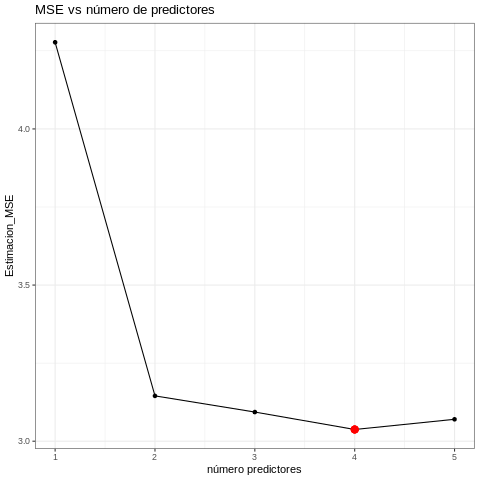

In [ ]:
# # Ploteamos
# %%R
# library(ggplot2)


# p <- ggplot(data = data.frame(n_predictores = 1:5, Estimacion_MSE = validation_error), aes(x = n_predictores, y = Estimacion_MSE)) +
#   geom_line() +
#   geom_point()
# # Se identifica en rojo el mínimo
# p <- p + geom_point(aes(x = n_predictores[which.min(validation_error)], y = validation_error[which.min(validation_error)]), colour = "red", size = 3)
# p <- p + scale_x_continuous(breaks = c(0:5)) +
#   labs(title = "MSE vs número de predictores", x = "número predictores") +
#   theme_bw()
# p